# Исследование результатов A/B-тестирования.

В ходе текущего исследования мы выполним анализ результатов А/В-тестирования изменений, связанных с внедрением улучшенной рекомендательной системы. Исследование результатов будет проводится на основе данных о техническом задании, календаря маркетинговых событий за 2020год, данных о действиях пользователей и участниках теста.

Цели исследования:
- оценка корректности проведения теста,
- анализ результатов теста.

Для того, что бы получить наиболее корректные результаты исследования, перед анализом теста нам потребуется проверить данные на соответствие техническому заданию.

Таким образом, исследование пройдет в несколько этапов:
1. Обзор и предобработка данных.
2. Проверка соответствия данных требованиям технического задания.
3. Исследовательский анализ данных.
4. Оценка результатов А/В теста.

## Оглавление. <a class="anchor" id="start"></a>

* [1. Обзор и предобработка данных](#1)
    * [1.1 Датасет "ab_project_marketing_events"](#1.1)
    * [1.2 Датасет "final_ab_new_users"](#1.2)
    * [1.3 Датасет "final_ab_events"](#1.3)
    * [1.4 Датасет "final_ab_participants](#1.4)
    * [1.5 Вывод](#1.5)
* [2. Проверка данных на соответствие требованиям технического задания](#2)
    * [2.1 Формирование тестовых групп](#2.1)
    * [2.2 Аудитория теста](#2.2)
    * [2.3 Время проведения теста](#2.3)
    * [2.4 События, совершенные пользователями в рамках теста.](#2.4)
    * [2.5 Вывод](#2.5)
* [3. Исследовательский анализ_данных](#3)
    * [3.1 Установка заданного лайфтайма пользователей](#3.1)
    * [3.2 Распределение событий на пользователя](#3.2)
    * [3.3 Распределение событий по дням.](#3.3)
    * [3.4 Вывод](#3.4)
* [4. Исследование конверсии по шагам..](#4)
    * [5.1 Построение событийной воронки.](#4.1)
    * [5.2 Проверка статистической значимости.](#4.2)
    * [5.3 Вывод.](#4.3)
* [5. Итоги исследования.](#5)

## 1. Обзор и предобработка данных. <a class="anchor" id="1"></a>

In [1]:
#установим пакет kaleido для отображения графиков plotly в формате png (для корректного воспроизведения на gitHub)

In [2]:
pip install -U kaleido

Note: you may need to restart the kernel to use updated packages.


In [3]:
#импортируем необходимые библиотеки
import pandas as pd
import datetime as dt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy import stats as st
import math as mth
import numpy as np
from datetime import datetime, timedelta
from datetime import date
from matplotlib import pyplot as plt

In [4]:
#считаем данные и сохраним в переменные
ab_project_marketing_events = pd.read_csv('https://code.s3.yandex.net/datasets/ab_project_marketing_events.csv')
final_ab_new_users = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_new_users.csv')
final_ab_events = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_events.csv')
final_ab_participants = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_participants.csv')

В связи с тем, что в нашем распоряжении несколько датасетов, мы проведем проверку и предобработку данных для каждого отдельно.

Для этого, создадим функцию, которая выведет основную информацию о датасете.

In [5]:
def get_info(df_name):
    
    """
    Функция принимает на вход название датасета
    и выводит первые пять строк, информацию о датасете и кол-во явных дубликатов
    
    """
    
    display(df_name.head())
    print('------------------------------')
    print('')
    print(df_name.info())
    print('')
    print('------------------------------')
    print('')
    print('Кол-во явных дубликатов в датасете:', df_name.duplicated().sum())

### 1.1 Датасет "ab_project_marketing_events". <a class="anchor" id="1.1"></a>

In [6]:
get_info(ab_project_marketing_events)

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


------------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes
None

------------------------------

Кол-во явных дубликатов в датасете: 0


В таблице представлена информация о маркетинговой активности в различных регионах. таблица состоит из 14 строк и 4х столбцов, дубликатов и пропусков в значениях нет.

Тип данных в столбцах с датами некорректен, преобразуем хранящиеся в них данные в тип datetime.

In [7]:
ab_project_marketing_events['start_dt'] = pd.to_datetime(ab_project_marketing_events['start_dt'])
ab_project_marketing_events['finish_dt'] = pd.to_datetime(ab_project_marketing_events['finish_dt'])

### 1.2 Датасет "final_ab_new_users". <a class="anchor" id="1.2"></a>

In [8]:
get_info(final_ab_new_users)

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


------------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB
None

------------------------------

Кол-во явных дубликатов в датасете: 0


В таблице "final_ab_new_users" содержится информация о пользователях, зарегистрировавшиеся с 7 по 21 декабря 2020 года. Пропуски и явные дубликаты отсутствуют. 

Однако, в таблице есть строковые значения - информация по региону и девайсу. А так же дата хранится в неверном формате.

Проверим, нет ли в этих столбцах неявных дубликатов и исправим тип даты в столбце с датой.

In [9]:
#преобразуем дату в нужный формат
final_ab_new_users['first_date'] = pd.to_datetime(final_ab_new_users['first_date'])

#выведем уникальные значения столбцов "region" и "device"
print(final_ab_new_users['region'].unique())
print('')
print(final_ab_new_users['device'].unique())

['EU' 'N.America' 'APAC' 'CIS']

['PC' 'Android' 'iPhone' 'Mac']


Неявные дубликаты так же отсутствуют.

### 1.3 Датасет "final_ab_events". <a class="anchor" id="1.3"></a>

In [10]:
get_info(final_ab_events)

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


------------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB
None

------------------------------

Кол-во явных дубликатов в датасете: 0


В датасете "final_ab_events" содержится информация о действиях новых пользователей.

Тип данных, хранящихся в столбце с датами, так же как и в предыдущих таблицах, некорректный. Изменим его на тип datetime.

Явных дубликатов а таблице нет, но присутствуют строковые значения - названия событий. Проверим, нет ли среди них ошибочных.

In [11]:
#преобразуем дату в нужный формат
final_ab_events['event_dt'] = pd.to_datetime(final_ab_events['event_dt'])

final_ab_events['event_name'].unique()

array(['purchase', 'product_cart', 'product_page', 'login'], dtype=object)

Неявные дубликаты так же отсутствуют. Однако, в столбце 'details', где хранятся дополнительные сведения о событии, отсутствует большое кол-во значений. Возможно, не для всех событий указывают какие-либо дополнительные сведения.

Проверим это предположение, определим для каких событий в датасете указана дополнительная информация.

In [12]:
#выведем все уникальные значения столбца 'event_name', для которых имеются данные в details
final_ab_events[final_ab_events['details'].notna()]['event_name'].unique()

array(['purchase'], dtype=object)

Дополнительная информация указана только для оплаты на сайте. Значит, для других событий не предполагается никаких дополнительных сведений.

Теперь проверим, для всех ли событий по оплате имеется дополнительная информация о стоимости покупки.

In [13]:
final_ab_events.query('event_name == "purchase"')['details'].isna().sum()

0

Отлично, для всех покупок указана их стоимость, данные полные.

### 1.4 Датасет "final_ab_participants". <a class="anchor" id="1.4"></a>

In [14]:
get_info(final_ab_participants)

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


------------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB
None

------------------------------

Кол-во явных дубликатов в датасете: 0


В таблице "final_ab_participants" хранится и нформация об участниках теста. Пропусков и явных дубликатов нет.

Проверим значения в столбцах "group" и "ab_test" на предмет ошибочных значений.

In [15]:
print(final_ab_participants['group'].unique())
print(final_ab_participants['ab_test'].unique())

['A' 'B']
['recommender_system_test' 'interface_eu_test']


Неявные дубликаты так же отсутствуют.

Данные подготовлены, можно приступать к проверке технического задания.

### 1.5 Вывод. <a class="anchor" id="1.5"></a>

В ходе предобработки данных мы: 
- проверили данные наличие пропусков значений;
- убедились, что отсутствующие значения - не ошибка;
- проверили данные на наличие явных дубликатов и ошибочных значений;
- преобразовали даты в тип datetime.

## 2. Проверка  данных на соответствие требованиям технического задания. <a class="anchor" id="2"></a>

### 2.1 Формирование тестовых групп. <a class="anchor" id="2.1"></a>

Согласну техничекому заданию у нас есть следующее описание тестовых групп:
- название теста: recommender_system_test,
- группы: А — контрольная, B — новая платёжная воронка,
- ожидаемое количество участников теста: 6000.

Изучим датасет "final_ab_participants" и проверим кол-во участников теста на соотвтествие ТЗ.

Так же, посмотрим, как распределяется кол-во участников тестирования по группам, и, т.к. в таблице присутствует информация о двух А/В-тестах, убедимся, что нет пересечений пользователей с конкурирующим А/В-тестом.

In [16]:
#отфильтруем данные по нашему тесту и сохраним в отдельную переменную
recommender_system_test = final_ab_participants.query('ab_test == "recommender_system_test"')

#посчитаем кол-во участников теста и кол-во участников по группам
users_per_group = (recommender_system_test
                   .groupby('group', as_index=False)
                   .agg({'user_id':'nunique'}))

print('Общее кол-во участников теста:', len(recommender_system_test))
users_per_group

Общее кол-во участников теста: 6701


,group,user_id
0,A,3824
1,B,2877


Общее кол-во участников соответствует ТЗ. Однако, распределение пользователей по группам несовсем равномерное: в контрольной группе на 1000 человек больше, чем в тестовой. 

Проведем дальнейшую проверку на соответствие техническому заданию и равномерность распределения пользователей по группам в разрезе важных критериев. Если рапределение по критериям будет равномерным, то разница в кол-ве человек в группах не должна исказить результаты тестирования.

Теперь проверим, есть ли пересечение участников со вторым А/В тестом.

In [17]:
#сгруппируем таблицу по id пользователя и посчитаем кол-во тестов в которых он примает участие
double_users = (final_ab_participants
                .groupby('user_id', as_index=False)
                .agg({'ab_test':'count'})
                .query('ab_test > 1')['user_id']
                .unique())


print('Кол-во пользователей, попавших в оба теста:', len(double_users))


Кол-во пользователей, попавших в оба теста: 1602


Более 1,5 тысяч пользователей попали в оба теста. Нам необходимо убедится, что их участие в конкурирующем тесте не окажет влияния на поведение и не исказит резльтаты нашего теста.

Для этого:
- проверим, к какой группе в конкурирующем тесте они относятся. Участники контрольной группы А (которые не видели изменений при втором тесте) не могут исказить результаты нашего тестирования;
- для участников группы В из второго теста проверим распределение по группам нашего теста. Если они распределны равномерно, то они не исказят результаты исследования, их можно будет оставить. Если же распределение будет неравномерным, то этих пользователей придется удалить.

In [18]:
#отфильтруем пользователей, которые попали в оба теста 
#и посчитаем кол-во в каждой из групп второго теста
double_users_A =(final_ab_participants
                 .query('user_id in @double_users & ab_test == "interface_eu_test" & group == "A"')['user_id']
                 .unique())

double_users_B =(final_ab_participants
                 .query('user_id in @double_users & ab_test == "interface_eu_test" & group == "B"')['user_id']
                 .unique())

print('Кол-во пользователей в группе А второго теста', len(double_users_A))
print('Кол-во пользователей в группе В второго теста', len(double_users_B))

Кол-во пользователей в группе А второго теста 819
Кол-во пользователей в группе В второго теста 783


819 пользователей из группы А не представляют угрозы нашему тесту, остальных (783 человека) необходимо проверить. Для краткости описания назовем их "проблемными".

Для этого:
- посчитаем кол-во проблемных пользователей в каждой из групп нашего теста,
- посчитаем долю проблемных от общего кол-ва пользователей в каждой из наших групп,
- сравним доли.

In [19]:
#отфильтруем таблицу нашего теста по проблемным пользователям,
# сгруппируем по группе и посчитаем кол-во в каждой
doubles_per_group = (recommender_system_test
                     .query('user_id in @double_users_B')
                     .groupby('group', as_index=False)
                     .agg({'user_id':'nunique'})
                     .rename(columns={'user_id':'problems_amt'}))
doubles_per_group

,group,problems_amt
0,A,439
1,B,344


In [20]:
#зададим функцию для определения равномерности распределенияя пользователей 
#в группа А и В по разным критериям

def check_proportion(success_1, success_2):
    
    """
    Функция принимает кол-во пользователей по проверяемому критерию в каждой из групп,
    считает долю этих пользователей от общего числа участников в группах
    и проверяет, является различие в долях статистически значимым
    """
    
    successes = np.array([success_1, success_2])

    trials = np.array([users_per_group.query('group=="A"')['user_id'], 
                   users_per_group.query('group=="B"')['user_id']])

    # пропорция успехов в первой группе:
    p1 = successes[0]/trials[0]

    # пропорция успехов во второй группе:
    p2 = successes[1]/trials[1]

    # пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

    # разница пропорций в датасетах
    difference = p1 - p2 

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)  

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('Доля в первой группе равна:', p1*100)
    print('Доля во второй группе равна:', p2*100)

    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными') 
    


In [21]:
#зададим критический уровень статистической значимости
alpha = .05

#применим функцию и посчитаем доли проблемных пользователей в каждой группе
check_proportion(doubles_per_group.query('group=="A"')['problems_amt'], 
                 doubles_per_group.query('group=="B"')['problems_amt'])

Доля в первой группе равна: [11.48012552]
Доля во второй группе равна: [11.95689955]
p-значение:  [0.54759252]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Статистически значимых различий не выявлено. Значит, пользователи из группы В второго теста равномерно распределены по группам нашего теста и не окажут влияния на результаты теста. Оставляем их в данных для дальнейшего анализа.

### 2.2 Аудитория теста. <a class="anchor" id="2.2"></a>

Согласно техническому заданию аудитория теста дожна удовлетворять следующим условиям:
1. Участники теста должны быть зарегистрированы на сайте в период с 7 по 21 декабря 2020 года.
2. 15% пользователей из EU должны стать участниками теста.

Для проверки данных на соответствие с ТЗ, используем датасет "final_ab_new_users". 

Отфильтруем его по пользователям, которые являются участниками нашего теста, сохраним их в новую переменную и убедимся, что все пользователи были зарегистрированы в указанный по ТЗ период..

In [22]:
#отфильтруем данные по id пользователей, которые указаны в датасете участников теста
partiticipants = recommender_system_test["user_id"].unique()
recommender_new_users = final_ab_new_users.query('user_id in @partiticipants')

#определим минимальную и максимальную даты регистрации пользователей
print('Самая ранняя дата регистрации пользователей:', recommender_new_users['first_date'].min())
print('Самая поздняя дата регистрации пользователей:', recommender_new_users['first_date'].max())


Самая ранняя дата регистрации пользователей: 2020-12-07 00:00:00
Самая поздняя дата регистрации пользователей: 2020-12-21 00:00:00


Данные корректны, все пользователи были зарегистрированны в период, определенный техническим заданием.

Проверим, пользователи из каких регионов участвуют в тесте.

In [23]:
recommender_new_users['region'].unique()

array(['EU', 'APAC', 'CIS', 'N.America'], dtype=object)

Согласно ТЗ тест должен быть проведен только среди пользователей из Европы. Однако, среди зарегистрированных участников так же присутствуют пользователи из других стран.

Посчитаем, сколько таких пользователей зарегистрированно в тесте.

In [24]:
print('Кол-во пользователей из других регионов:', len(recommender_new_users.query('region != "EU"')['user_id']))
print('Доля пользователей из других регионов от общего числа участниклв теста:',
     round(len(recommender_new_users.query('region != "EU"')['user_id']) / len(recommender_new_users['user_id'])*100))

Кол-во пользователей из других регионов: 350
Доля пользователей из других регионов от общего числа участниклв теста: 5


350 пользователей из других стран попали в участники теста, что составляет 5% от общего кол-ва участников. Так как по ТЗ тестирование предполагалось прооводить среди пользователей из Европы, исключим их из исследования. Кроме того, в каждом регионе своя маркетинговая активность, которая может исказить результаты теста. 

In [25]:
#удалим из таблиц пользователей всех участников не из европы
recommender_new_users = recommender_new_users.query('region == "EU"')
eu_users = recommender_new_users["user_id"].unique()

recommender_system_test = recommender_system_test.query('user_id in @eu_users')


Теперь посмотрим, набралось ли в качестве участников 15% зарегистрировавшихся пользователей из Европы.

Убедимся, что все пользователи из Европы регистрировались до 21.12.2020.

In [26]:
final_ab_new_users.query('region == "EU"')

print('Самая ранняя дата регистрации пользователей:', 
      final_ab_new_users.query('region == "EU"')['first_date'].min())
print('Самая поздняя дата регистрации пользователей:', 
      final_ab_new_users.query('region == "EU"')['first_date'].max())


Самая ранняя дата регистрации пользователей: 2020-12-07 00:00:00
Самая поздняя дата регистрации пользователей: 2020-12-23 00:00:00


В таблице присутствуют пользователи из Европы, зарегистрировавшиеся после 21го декабря. Учтем это при расчете процентной доли участников.

In [27]:
#установим максимальную дату регистрации
max_date = date(2020, 12, 21)

In [28]:
print('Доля участников от общего кол-ва европейских пользователей:', 
     round(len(recommender_new_users) / \
           len(final_ab_new_users.query('region == "EU" and first_date <= @max_date')) *100))

Доля участников от общего кол-ва европейских пользователей: 15


15% пользователей из Европы приняли участие в тесте. Объем данных удовлетворяет техническому заданию.

### 2.3 Время проведения теста. <a class="anchor" id="2.3"></a>

Согласно техническому заданию А/В тест проводился в период с 07.12.2020 по 04.01.2021. 

Что бы избежать искажение результатов, необходимо проверить, пересекается ли время проведения теста с какими-либо маркетинговыми акциями и мероприятиями. Любые маркетинговые мероприятия могут стать причиной изменения поведения пользователей, что может быть неверно интерпретировано в пользу преимуществ новой рекомендательной системы, на самом деле не являясь таковым.

Ознакомимся с информацией о маркеинговых акциях.

In [29]:
ab_project_marketing_events

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


В разных регионах маркетнговые акции проходят в разные периоды. Проверим, пересекаются даты нашего теста с какими- либо акциями.

In [30]:
#зададим даты начала и окончания теста
test_start_date = date(2020, 12, 7)
test_finish_date = date(2021, 1, 4)


In [31]:
#зададим функцию для определения пересекающихся данных
def check_dates(row):
    
    """
    функция принимает на вход кажздый солбец датафрема 
    и сравнивает даты акций и теста:
    если дата начала или окончания маркетинговой акции лежит между 
    датами начала и окончания теста, то функция выведет значение True
    
    """
    
    start_dt_adds = row['start_dt']
    finish_dt_adds = row['finish_dt']
    
    if test_start_date < start_dt_adds < test_finish_date:
        return True
    
    if test_start_date < finish_dt_adds < test_finish_date:
        return True
    
    else:
        return False

In [32]:
#применим функцию и создадим столбец с указанием инфо о том, пересекаются ли даты с тестом 
ab_project_marketing_events['is_crossed'] = ab_project_marketing_events.apply(check_dates, axis=1)

#выведем акции, которые пересекаются с нашим тестом
ab_project_marketing_events.query('is_crossed == True')

/var/folders/jg/_twx4_tn15z6p3pytfwd61k40000gp/T/ipykernel_46926/188301237.py:15: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if test_start_date < start_dt_adds < test_finish_date:
/var/folders/jg/_twx4_tn15z6p3pytfwd61k40000gp/T/ipykernel_46926/188301237.py:18: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if test_start_date < finish_dt_adds < test_finish_date:


,name,regions,start_dt,finish_dt,is_crossed
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03,True
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07,True


Два маркетинговых мероприятия пересекаются с датами нашего теста.

Акция "CIS New Year Gift Lottery" проводится в странах СНГ, поэтому не окажет влияния на наш тест.

А вот акция "Christmas&New Year Promo" начинается 25.12.2020 и заканчивается 03.01.2021. То есть длится в течении второй половины нашего А/Б-тестирования.

<span style="color:brown">По-хорошему, проводить А/Б - тест накануне Нового года, самого масштабного праздника в году во всем мире, не имеет смысла. Чем ближе дата Нового года, тем сильнее возрастает активность пользователей вне зависимости от изменений на сайте. Это может привести к неправильной интерпритации результатов, когда повышение конверсии будет расценено как результат новой рекомендательной системы, что может быть ошибочным.</span>

Однако, тест уже проведен, поэтому необходимо проанализировать, как наступление акции повлияло на активность пользователей и принять решение о том, оставлять события за период акции или же исключать из исследования.

При проведении исследовательского анализа данных далее, посмотрим на распределение событий во времени и влияние акции на него.

### 2.4 События, совершенные пользователями в рамках теста. <a class="anchor" id="2.4"></a>

Согласно ТЗ дата окончания А/Б-теста - 04.01.2021 года. Посмотрим, данные о скольких событиях и за какой период у нас имеются по факту.

In [33]:
print('Дата самого раннего события', final_ab_events['event_dt'].min())
print('Дата самого позднего события', final_ab_events['event_dt'].max())

Дата самого раннего события 2020-12-07 00:00:33
Дата самого позднего события 2020-12-30 23:36:33


У нас имеются события за временной период с 07.12.2020 по 30.12.2021. То есть период совершения событий не соответствует ТЗ, не хватает информации еще о 5ти днях проведения теста.

В связи с тем, что по результатам теста предполагается изучение поведение пользователей в течении 14 дней с момента регистрации, а у нас отсутствуют данные за 5 последних дней теста, нам потребуется дополнительно исследовать пользователей, которые не успели "прожить" установленный "срок жизни" и, возможно, исключить некоторых из них из исследования.

### 2.5 Вывод. <a class="anchor" id="2.5"></a>

В ходе проверки данных на соответствие техническомй заданию при запуске А/Б тестирования было определено, что:

1. Изначально в тесте было зарегистрировано 6701 пользователь.


2. Распределение пользователей проведено неравномерно, группа А почти на 1000 человек больше группы В. При этом, более 1.5тыс пользователей одновременно принимают участие в двух А/Б-тестах.


3. Среди участников теста присутствовали 350 пользователей не из стран Европы, что не соответсвует ТЗ. Эти пользователи были исключены ищз исследования.


4. Для анализа результатов предоставлены неполные данные - отсутствует информация об активности пользователей за период с 31.12 по 04.01.

## 3. Исследовательский анализ данных. <a class="anchor" id="3"></a>

Для дальнейшего анализа сведем все имеющиеся данные о тесте в единую таблицу, в клоторую войдут:
- id пользователей,
- группа А/В-теста,
- дата регистрации пользователя,
- устройство, с которого происходила регистрация,
- события, совершенные пользователями,
- даты событий,
- доп.сведения о событиях.


In [34]:
final_ab_events.head()

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


In [35]:
#создаем таблицу с объединенной информацией
full_info = (recommender_system_test[['user_id', 'group']]   #к данным о id и группе пользователя
             .merge(recommender_new_users[['user_id', 'first_date', 'device']], 
                    on='user_id', 
                    how='left')   #добавляем информацию о дате и устройстве регистрации
             .merge(final_ab_events, 
                    on='user_id', 
                    how='left')    #добавляем инфо о событиях
             .rename(columns={'first_date':'reg_date'}))

get_info(full_info)

,user_id,group,reg_date,device,event_dt,event_name,details
0,D1ABA3E2887B6A73,A,2020-12-07,PC,2020-12-07 14:43:27,purchase,99.99
1,D1ABA3E2887B6A73,A,2020-12-07,PC,2020-12-25 00:04:56,purchase,4.99
2,D1ABA3E2887B6A73,A,2020-12-07,PC,2020-12-07 14:43:29,product_cart,NaN
3,D1ABA3E2887B6A73,A,2020-12-07,PC,2020-12-25 00:04:57,product_cart,NaN
4,D1ABA3E2887B6A73,A,2020-12-07,PC,2020-12-07 14:43:27,product_page,NaN


------------------------------

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26290 entries, 0 to 26289
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     26290 non-null  object        
 1   group       26290 non-null  object        
 2   reg_date    26290 non-null  datetime64[ns]
 3   device      26290 non-null  object        
 4   event_dt    23420 non-null  datetime64[ns]
 5   event_name  23420 non-null  object        
 6   details     3196 non-null   float64       
dtypes: datetime64[ns](2), float64(1), object(4)
memory usage: 1.6+ MB
None

------------------------------

Кол-во явных дубликатов в датасете: 0


У нас получилась таблица с записями о 26290 событиях и пользователях, которые стали участниками теста, но не совершили никаких событий на сайте. Об этом говорит наличие пропуском в столбцах "event_dt", "event_dt".


Теперь у нас есть полные данные для проведения исследовательского анализа.

### 3.1 Установка заданного лайфтайма пользователей. <a class="anchor" id="3.1"></a>

Для того, что бы провести корректный анализ в соответствии с ожидаемым эффектом от тестирования, нам необходимо оставить в таблице только те события, которые были совершены пользователями в течении первых 14 дней с момента регистрации.

In [36]:
#зададим горизонт анализа 13 дней, т.к.день лайфтайм 14 дней, включая день регистрации 
analisys_horizon = 13

In [37]:
#зададим функцию для определения событий, входящих в лайфтаим пользователя
def find_events(row):
    
    """
    Функция принимает на вход строку датафрейма, задает максимальную дату события 
    согласно дате регистрации пользоват и сравнивает дату события с максимальной.
    
    Если событие случилось в установленнный лайфтайм, оно помечается как True.
    Если позже - False.
    
    """
    
    max_date = row['reg_date'] + timedelta(days=analisys_horizon)
    
    if row['event_dt'] > max_date:
        return False
    
    else:
        return True

In [38]:
#применим функцию к датафремй, создав столбец "proper_event"
full_info['proper_event'] = full_info.apply(find_events, axis=1)

Посчитаем, сколько событий были совершены после установленного горизонта анализа.

In [39]:
len(full_info.query('proper_event == False'))

1043

Всего 1043 события выходят за рамке определенного ТЗ лайфтайма. Удалим эти записи из таблицы и проверим, не потеряли ли мы каких-либо пользователей после удаления записей с событиями.

In [40]:
#удаляем данные о событиях, входящих за дату горизонта и столбец "proper_event" (больше не потребуется)
full_info = full_info.query(('proper_event == True'))
full_info = full_info.drop(columns='proper_event') 

#проверяем кол-во пользователей
full_info['user_id'].nunique()

6351

Ни один пользователь не был потерян.

Теперь разберемся с теми пользователями, которые не успели прожить положенный период. Так как у нас есть данные только до 30.12, нам необходимо определить всех пользователей, которые были зарегистрированы на тест позднее, чем 13 дней до этой даты. 

In [41]:
#определим дату, с которой регистрирующиеся пользователи не успевали прожить 14 дней
last_suitable_registration_date = full_info['event_dt'].max() - timedelta(days=analisys_horizon-1)
last_suitable_registration_date

Timestamp('2020-12-17 23:38:29')

Для всех пользователей, зарегистрировавшиеся позже 17.12.2020, мы не имеем возможности отследить действия на протяжении 14 дней с момента регистрации. 

Что бы избежать попадания таких пользователей в категорию "несовершивших целевое действие", тем самым изказив реальные показатели конверсии, мы проведем следующие действия:
1. Среди неуспевших прожить 14 дней пользователей мы отберем тех, кто уже успел совершить покупку на сайте. Т.е. те, кто уже успел конвертироваться в покупатели, остануться в исследовании.
2. Пользователей, неуспевших совершить покупку, мы удалим. Не исключено, что за оставшиеся дни своего лайтайма они успели совершить целевое действие на сайте. Но если мы оставим сейчас их в исследовании, то они добавятся к доле тех, кто не дошел до покупки и могут занизить реальные показатели конверсии.

In [42]:
#создадим список с зарегистрировавшимися после 17 декабря
late_users = (full_info.query('reg_date > @last_suitable_registration_date')['user_id'].unique())

In [43]:
#определим поздних пользователей, которые успели конвертироваться в покупатели
late_users_converted = (full_info
                        .query('event_name =="purchase" & user_id in @late_users')['user_id']
                        .unique())

#определим поздних пользователей, которые не успели конвертироваться в покупатели
late_users_not_converted = (full_info
                            .query('user_id in @late_users & user_id not in @late_users_converted')['user_id']
                            .unique())

#посчитаем и выведем их кол-во
print("Кол-во совершивших покупку:", len(late_users_converted))

#посчитаем и выведем кол-во тех, кто не дошел до конечного шага
print("Кол-во несовершивших покупку:", len(late_users_not_converted))

Кол-во совершивших покупку: 437
Кол-во несовершивших покупку: 1488


Всего 437 пользователя остается в таблице, а 1488 пользователей мы вынуждены исключить из исследования.

In [44]:
#оставим в таблице только тех пользователей, которые не входят в список late_users_not_converted
full_info = full_info.query('user_id not in @late_users_not_converted')

#посчитаем кол-во оставшихся в тесте пользователей.
print("Кол-во пользователей, оставшихся в датасете:", full_info['user_id'].nunique())

#посчитаем долю оставшихся от первоначального колв-ва участников.
print('Доля оставшихся от первоначального кол-ва участников теста:',
     round(full_info['user_id'].nunique()/len(recommender_system_test)*100,1))

#проверим распределение оставшихся пользователей по группам
full_info.groupby('group')['user_id'].nunique()

Кол-во пользователей, оставшихся в датасете: 4863
Доля оставшихся от первоначального кол-ва участников теста: 76.6


group
A    2916
B    1947
Name: user_id, dtype: int64

У нас осталось 4863 участника теста, что составляет 76.6% от первоначального кол-ва участников.

Из-за отсутсвия заявленных в ТЗ данных нам пришлось урезать данные, при этом кол-во участников теперь не совпадает с ожидаемым кол-вом по техническому заданию.

Проверим данные в [онлайн-калькуляторе Optimizely](https://www.optimizely.com/sample-size-calculator/?conversion=20&effect=5&significance=95#/?conversion=50&effect=10&significance=98).

### 3.2 Распределение событий на пользователя. <a class="anchor" id="3.2"></a>

Теперь посмотрим, как распределяется кол-во событий на пользователя в контрольной и тестовой группах.

Для этого сначала посчитаем кол-во событий по каждому пользователю и построим визуализацию с учетом принадлежности к группе.

In [45]:
events_per_user= (full_info
                  .groupby(['user_id', 'group'], as_index=False)
                  .agg({'event_dt':'count'})
                  .rename(columns={'event_dt':'events_amt'})
                  .sort_values(by='events_amt', ascending=False))
events_per_user

,user_id,group,events_amt
4007,CED71698585A2E46,A,24
329,1198061F6AF34B7B,B,24
3583,B8EF6F0325A9979F,A,21
322,115EBC1CA027854A,B,21
2612,89545C7F903DBA34,B,21
...,...,...,...
1485,4DE79A3E0B7A6BCB,A,0
1484,4DE67C107ED2A155,B,0
1482,4DE505AB54D6BEAF,A,0
3162,A4B65E478C998919,A,0


Согласно полученным данным на пользователя приходтся от 0 до 24 событий за две недели. Посмотрим распределение.

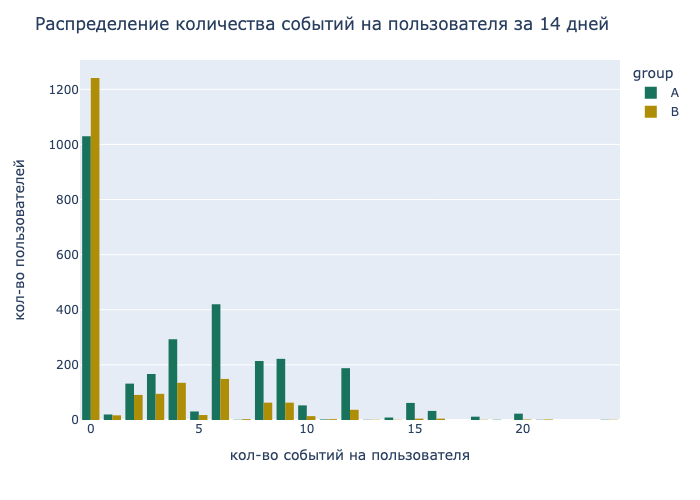

In [46]:
#построим гистограмму распределения кол-ва событий на пользователя
fig = px.histogram(events_per_user, 
                   x='events_amt',
                   color='group',
                   color_discrete_sequence=['#19725c','#ae8e06'],
                   barmode='group')

fig.update_layout(title='Распределение количества событий на пользователя за 14 дней',
                   xaxis_title='кол-во событий на пользователя',
                   yaxis_title='кол-во пользователей')

fig.show(renderer="png")

На гистограмме видно, что бОльшая часть пользователей, вообще, не совершила никаких действий на сайте с момента регистрации.

Следующим шагом мы исследуем этот вопрос, а пока построим гистограмму без неактивных пользователей для лучшей наглядности.

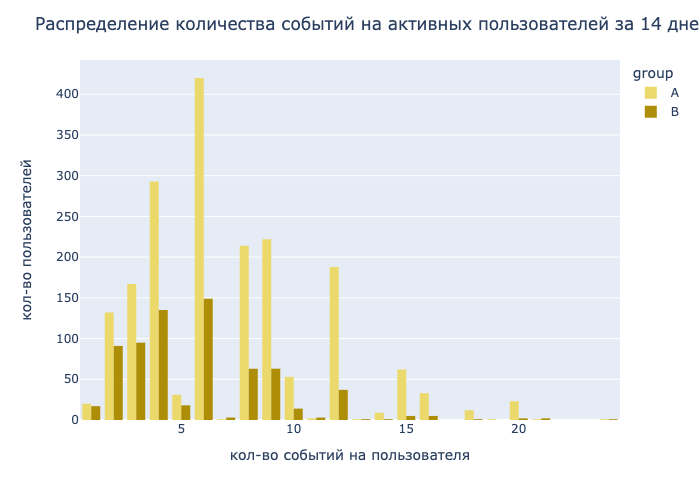

In [47]:
#построим гистограмму распределения кол-ва событий на активного пользователя
fig = px.histogram(events_per_user.query('events_amt != 0'), 
                   x='events_amt',
                   color='group',
                   color_discrete_sequence=['#ecd96c','#ae8e06'],
                   barmode='group')

fig.update_layout(title='Распределение количества событий на активных пользователей за 14 дней',
                   xaxis_title='кол-во событий на пользователя',
                   yaxis_title='кол-во пользователей')

fig.show(renderer="png")

Теперь на графике заметно, что в распределении кол-ва событий на пользователя для обеих групп, в целом, нет видимых различий.

Теперь разберемся с пользователями, которые не совершили на сайте ни одбного действия с момента регистрации.

Найдем этих пользователей и посчитаем их долю в каждой группе.

In [48]:
#заменим значение в столбце на event_name на "inactive" для неактивных пользователей
full_info['event_name'] = full_info['event_name'].fillna('inactive')

#уберем время из столбца с датой события
full_info['event_dt'] = full_info['event_dt'].dt.date

In [49]:
print('Доля неактивных пользователе в группе А:',
     round(len(full_info.query('event_name == "inactive" and group=="A"')) / \
           full_info.query('group=="A"')['user_id'].nunique()*100))


print('Доля неактивных пользователе в группе А:',
     round(len(full_info.query('event_name == "inactive" and group=="B"')) / \
            full_info.query('group=="B"')['user_id'].nunique()*100))

Доля неактивных пользователе в группе А: 35
Доля неактивных пользователе в группе А: 64


Доля неактивных пользователей в контрольной группе почти в 2 раза меньше, чем в тестовой группе, распределение неравномерно. 

Посмотрим, как распределяется количество неактивных пользователей по дню регистрации для каждой группы.

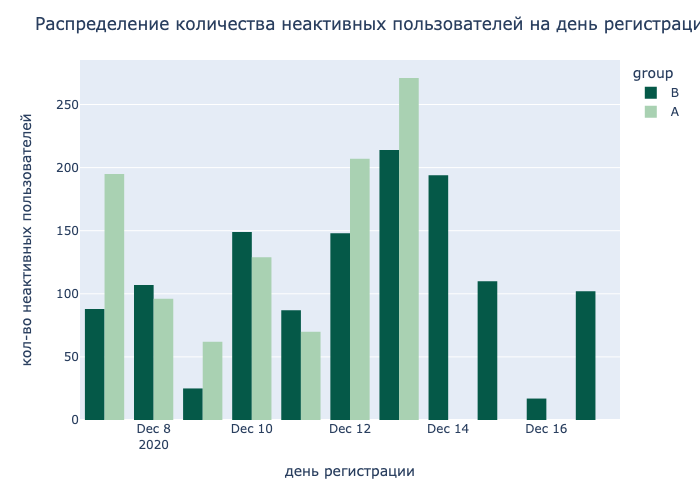

In [50]:
fig = px.histogram(full_info.query('event_name == "inactive"'), 
                   x='reg_date',
                   color='group',
                   color_discrete_sequence=['#055948','#a9d1b2'],
                   barmode='group')

fig.update_layout(title='Распределение количества неактивных пользователей на день регистрации',
                   xaxis_title='день регистрации',
                   yaxis_title='кол-во неактивных пользователей')

fig.show(renderer="png")

На гистограмме заметна интересная закономерность. 

Все пользователи, которые не совершили ни одного события на сайте, были зарегистрированы в период:
- `с 7-го по 13е декабря включительно` для ***группы А***, 
- `с 7-го по 17е декабря включительно` для ***группы В***. 

В такой ситуации крайне маловероятно, что причина - человеческий фактор. Если бы среди пользователей-участников теста были бы те, кто просто не воспользовался услугами сайта, то распределения таких пользователей было бы более хаотичное и охватывало бы весь период времени. Тем не менее, мы наблюдаем, что среди пользоватлей, зарегистрировавшихся 18-21-го декабря, нет ни одного неактивного.

В нашем же случае наиболее вероятная причина отсутствия информации о событиях - технические проблемы, которые могли возникнуть либо при выгрузке данных, либо при регистрации пользователей/делении на группы, сбора данных.

Учитывая причину отсутствия активности для этих пользователей, мы не можем включить их в исследование. В противном случае они повлияют на коэффициент конверсии в худшую сторону, что скажется на корректности принятого по результатам АБ-теста решения.

Исключим их из данных.

In [51]:
full_info = full_info.query('event_name != "inactive"')

In [52]:
#посчитаем, сколько пользователей у нас осталось
full_info.groupby('group').agg({'user_id':'nunique'})

,user_id
group,
A,1886
B,706


В группе В осталось всего 706 пользователей, что является недостаточным кол-вом для корректного проведения теста. Велика вероятность, что полученные результаты не будут максимально достоверными, так как статистическая мощность теста будет знчительно ниже ожидаемой.

<span style="color:brown">**!! В связи с тем, что тест уже проведен, наиболее целесообразным представляется запросить у ответственных лиц, при налчии технической возможности, проверить алгоритмы сбора и выгрузки данных, постараться найти проблему и, возможно, достать недостающую информацию о неактивных пользователях. В этом случае можно будет пересмотреть результаты проведенного тестирования, так как при достижении требуемого размера выборки мощность теста возрастает.**</span>

### 3.3 Распределение событий по дням. <a class="anchor" id="3.3"></a>

Посмотрим, как события распределяются во времени. 

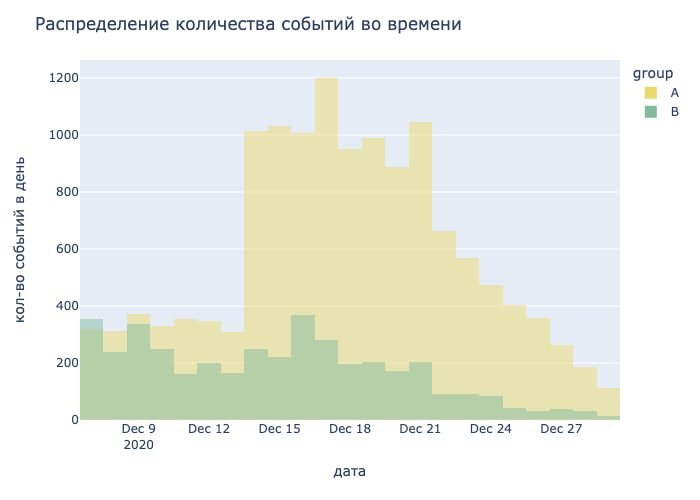

In [53]:
#построим гистограмму распределения событий во времени
fig = px.histogram(full_info, 
                   x=full_info['event_dt'],
                   color='group',
                   color_discrete_sequence=['#ecd96c','#81ba9c'],
                   barmode='overlay')

fig.update_layout(title='Распределение количества событий во времени',
                   xaxis_title='дата',
                   yaxis_title='кол-во событий в день')

fig.show(renderer="png")

На гистограммае отчетливо видно, что начиная с 22го декабря кол-во событий в группе А начинает стабильно снижаться, для группы В снижение менее равномерное, однако, так же присутствует. Это объясняется тем, что большую часть пользователей, на лайфтам которых приходится этот период, нам пришлось удалить из_за отсутствия данных за 5 дней проведени тестирования.

***Для группы А*** так же заметно резкое увеличение кол-ва событий, начиная с 14.12.2020. Как раз именно с 4го декабря для группы А, вероятнее всего, налаживают логику сбора/выгрузки данных. Поэтому "исчезают" неактивные пользователи (разбирали на предыдущем шаге), и резко увеличивается кол-во совершаемых за день событий.



***Для группы В***, вероятнее всего, технические проблемы не были решены до конца. До 17.12 в системы были неполадки с регистрацией активности пользователей, а начиная с 22.12 часть пользователей была исключена из анализа.

В связи с чем, распределение кол-ва событий по дням в разных группах нашего тестирования неравномерно.


<span style="color:brown">**!! Отсутствие качественной системы сбора данных во время тестирования, так же может привести к некорректным результатам.**</span>

Теперь посчитаем среднее кол-во событий на пользователя в день. Особое внимание обратим на даты проведения маркетинговой акции.

In [54]:
#сгруппируем таблицу по дате события, посчитаем кол-во пользователей и событий в этот день
avg_events_per_day= (full_info
                     .groupby(['event_dt', 'group'], as_index=False)
                     .agg({'user_id':'nunique',
                           'event_name':'count'})
                     .rename(columns={'event_name':'events_amt'})
                     .sort_values(by='event_dt'))


#добавим солбец со средним кол-вом событий на пользователя в день
avg_events_per_day['avg_amount'] = round(avg_events_per_day['events_amt']/avg_events_per_day['user_id'], 1)

Построим график с разбивкой по группам.

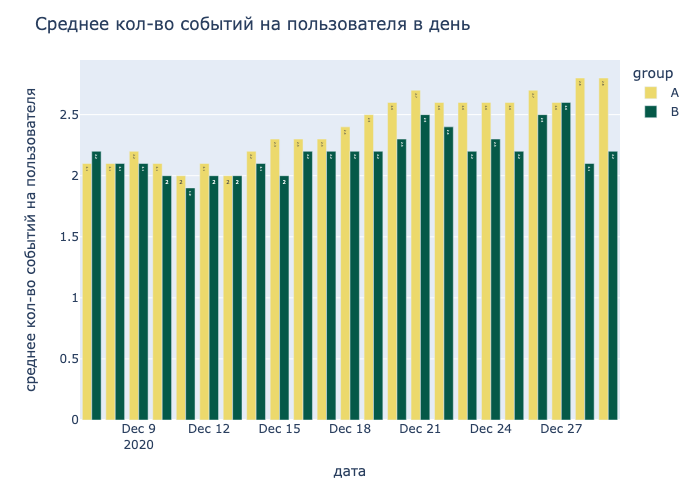

In [55]:
#построим столбчатую диаграмму
fig = px.bar(
    avg_events_per_day, 
    x='event_dt', 
    y='avg_amount' ,
    text='avg_amount',
    color = 'group',
    barmode = 'group',
    color_discrete_sequence = ['#ecd96c', '#055948']
    )

fig.update_layout(
                  title='Среднее кол-во событий на пользователя в день',
                  xaxis_title='дата',
                  yaxis_title='среднее кол-во событий на пользователя' 
                  )
fig.show(renderer="png")

- `Для группы В` среднее кол-во событий в день варьируется в пределах 2-2.5, 
- `Для группы А` этот показатель чуть выше и доходит до 2.8.

***Так же можно заметить, что для группы А*** показатель среднего кол-во событий начинает расти с 15 декабря, что может быть связано, как уже было сказано выше, с решением технических сложностей. К 20-му декабря он доходит до 2.6 событий на человека и не падает ниже до окончания изучаемогго периода. При этом, не наблюдается резкий рост кол-ва событий на пользователя после 25.12 (дата начала маркетинговой акции), что говорит об отсутствии заметногот влияния акции на поведение пользователей.

***Для группы В*** есть единичные дни, когда среднее кол-во событий на пользователя чуть выше обычного - 2.5 и 2.6. Однако, в целом, для группы В значение этого показателя стабильно 2-2.3 на протяжении всего периода. Влияние маркетинговой акции так же незамечено.

### 3.4 Вывод. <a class="anchor" id="3.4"></a>

В ходе исследовательского анализа было выявлено, что для более, чем 2тыс пользователей отсутствует информация об активности после регистрации на сайте:
- `для группы А` эта проблема распространяется на период с 7го по 13е декабря,
- `для группы В` - c 7го до 17го декабря. 

При этом, согласно диаграмме распределения кол-ва событий по дням, ситуация для группы В с 14 декабря стабилизировалась,  о чем говорит резкий скачок активности пользователей, переходящий в бошлее равномерное распределение в течении следующей недели.

Для группы В эта проблема, вероятнее всего, не была решено полностью. Активность пользователей в течении всего периода времени более равномерная.

Это так же заметно по динамике показатоеля среднего кол-ва событий на пользователя:
- `Для группы В` среднее кол-во событий в день варьируется в пределах 2-2.5, есть единичные дни, когда среднее кол-во событий на пользователя чуть выше обычного - 2.5 и 2.6. Однако, в целом, для группы В значение этого показателя стабильно 2-2.3 на протяжении всего периода.
- `Для группы А` этот показатель чуть выше и доходит до 2.8. При этом, в начале периода он равен значению 2.1, а с 15 декабря наблюдается рост.

Так же можно заметить, что резкий рост кол-ва событий на пользователя после 25.12 (дата начала маркетинговой акции) не наблюдается, что говорит об отсутствии заметногот влияния акции на поведение пользователей.

Кроме того, из-за отсутствия данных о событиях, совершенных в перирд с 31.12 по 04.01, нам пришлось исключить из исследования 1488 участника. Это привело к уменьшению размера группы В до кол-ва, несоответствующего минимальному размеру выборки, рассчитанному в калькуляторе А/Б-тестов.


<span style="color:brown">**!! Некачественный сбор данных во время тестирования может привести к некорректным результатам его анализа.**</span>

<span style="color:brown">**!! В связи с тем, что тест уже проведен, наиболее целесообразным представляется запросить у ответственных лиц, при налчии технической возможности, проверить алгоритмы сбора и выгрузки данных, постараться найти проблему и, возможно, достать недостающую информацию о неактивных пользователях. В этом случае можно будет пересмотреть результаты проведенного тестирования, так как при достижении требуемого размера выборки мощность теста возрастает.**</span>


## 4. Исследование конверсии по шагам. <a class="anchor" id="4"></a>

### 4.1 Построение событийной воронки. <a class="anchor" id="4.1"></a>

Теперь приступим к изучению имеющихся данных. Посчитаем кол-во уникальных пользователей для каждого шага и построим воронки для каждой из групп.

In [56]:
#построим сыодную таблицу по подсчету кол-ва пользователей на каждом шаге по группам
events_funnel = (full_info
                  .pivot_table(index='event_name', 
                               columns='group', 
                               values='user_id', 
                               aggfunc='nunique')
                  .reset_index()
                  .sort_values(by='A', ascending=False))

events_funnel.columns = ['event_name', 'A', 'B']

events_funnel

,event_name,A,B
0,login,1886,705
2,product_page,1225,407
3,purchase,833,249
1,product_cart,569,203


Согласно полученным данным вырисовывается следующая последовательность действий: 

***login -> product_page -> purchase -> product_cart***

Однако, логически, оплата должна быть расположена в самом основании воронки, т.к., по сути, является завершительным действием. В данной ситуауии, вероятно, на сайте присутствует возможность совершить покупку, например, в один клик, минуя корзину. Всвязи с этим, кол-во пользователей, совершивших покупку больше, чем тех, кто попал в корзину.

Тем не менее, для построения воронки, мы разместим события в логической последовательности.

In [57]:
events_funnel = events_funnel.reindex([0,2,1,3])
events_funnel

,event_name,A,B
0,login,1886,705
2,product_page,1225,407
1,product_cart,569,203
3,purchase,833,249


Посчитаем конверсию от общего кол-ва пользователей для каждого шага в каждой из групп и построим визуализацию.

In [58]:
#посчитаем конверсию в группе А, запишем в столбец
events_funnel['A-convers,%'] = round(events_funnel['A'] / (full_info
                                                           .query('group=="A"')['user_id']
                                                           .nunique())*100)

#посчитаем конверсию в группе А, запишем в столбец
events_funnel['B-convers,%'] = round(events_funnel['B'] / (full_info
                                                           .query('group=="B"')['user_id']
                                                           .nunique())*100)
events_funnel

,event_name,A,B,"A-convers,%","B-convers,%"
0,login,1886,705,100.0,100.0
2,product_page,1225,407,65.0,58.0
1,product_cart,569,203,30.0,29.0
3,purchase,833,249,44.0,35.0


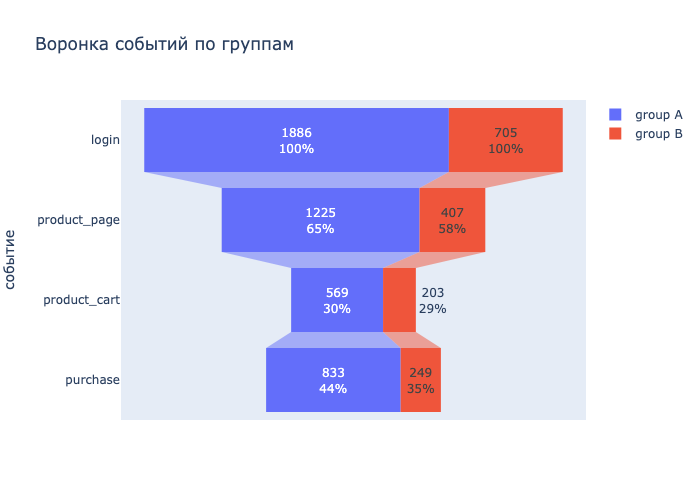

In [59]:
fig = go.Figure()

fig.add_trace(go.Funnel(
    name = 'group A',
    y = events_funnel['event_name'],
    x = events_funnel['A'],
    textinfo = "value+percent initial"))

fig.add_trace(go.Funnel(
    name = 'group B',
    y = events_funnel['event_name'],
    x = events_funnel['B'],
    textinfo = "value+percent initial"))

fig.update_layout(title='Воронка событий по группам',
                   yaxis_title='событие')

fig.show(renderer="png")

Согласно техническому заданию, ожидаемый эффект от изменений в рекомендательной системе заключается в улучшение каждой метрики не менее, чем на 10% в течении первых 14 дней с момента регистрации.

На полученной воронке отчетливо видно, что показатели тестовой группы значительно проигрывают показателям контрольной группы. 

Посчитаем разницу конверсий.

In [60]:
#посчитаем разницу конверсий на каждом шаге
events_funnel['con_diff,%'] = round((events_funnel['B-convers,%']/events_funnel['A-convers,%']-1)*100,1)
events_funnel

,event_name,A,B,"A-convers,%","B-convers,%","con_diff,%"
0,login,1886,705,100.0,100.0,0.0
2,product_page,1225,407,65.0,58.0,-10.8
1,product_cart,569,203,30.0,29.0,-3.3
3,purchase,833,249,44.0,35.0,-20.5


Полученные расчеты показали разницу в конверсиях на шагах:
- `"product_page"` - 10.8%,
- `"product_cart"` - 3.3%,
- `"purchase"` - 20.5%

Однако, эта разница не в пользу тестовой группы. Проверим, являются ли изменения статистически значимыми.


### 4.2 Проверка статистической значимости. <a class="anchor" id=""></a>

Для того, что бы получить финальные результаты проверки теста, оценим статистическую значимость различий в конверсиях.

Таким образом, у нас формируется 3 пары гипотез:
1. - Нулевая гипотеза - `"Доли пользователей, посмотревших страницу товара(product_page), равны"`. 
   - Альтернативная гипотеза - `"Между долями пользователей есть значимая разница"`.
   
3. - Нулевая гипотеза - `"Доли пользователей, попавших в корзину, равны"`. 
   - Альтернативная гипотеза - `"Между долями пользователей есть значимая разница"`.
   
4. - Нулевая гипотеза - `"Доли пользователей, оплативших товар, равны"`.
   - Альтернативная гипотеза - `"Между долями пользователей есть значимая разница"`.
   
Зададим уровень доверения в 95%. Однако, в связи с тем, что на одних данных мы будем проверять 3 гипотезы, применим поправку на множественность гипотез при определении уровня статистической значимости при каждом сравнении. 

Так как гипотез много, применим метод Шидака. Это сохранит мощность теста, но учтет множественность гипотез.

In [61]:
#зададим значение alpha
alpha = 0.05

#считаем альфа с поправкой Шидака на 3 гипотезы
shidak_alpha = 1 - (1 - alpha)**(1/3)   

In [62]:
#зададим функцию проверки гипотез
#передадим ей индекс строки события, номер 1й группы, номер 2й группы, кол-во проверяемых гипотез
def check_hypothesis(event):
    
    #задаем кол-во уникальных пользователей в группах
    group_a_total = full_info.query('group=="A"')['user_id'].nunique()
    group_b_total = full_info.query('group=="B"')['user_id'].nunique()
    
    
    successes = np.array([events_funnel.query('event_name==@event')['A'],
                         events_funnel.query('event_name==@event')['B']])
    trials = np.array([group_a_total, group_b_total])
   
    
#пропорция успехов в первой группе:
    p1 = successes[0]/trials[0]

#пропорция успехов во второй группе:
    p2 = successes[1]/trials[1]

#пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

#разница пропорций в датасетах
    difference = p1 - p2 
    
#считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

#задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)
    
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    
#выводим информацию о проверяемых группах и событии    
    print("Событие:", event)
    print('p-значение: ', p_value)

#выводим результат работы функции
    if p_value < shidak_alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print(
            'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
        ) 
    return

In [63]:
for event in events_funnel['event_name'].unique():
    
    if event != 'login':
        check_hypothesis(event)
        print()
        print('-------------------------')
        print()

Событие: product_page
p-значение:  [0.00060825]
Отвергаем нулевую гипотезу: между долями есть значимая разница

-------------------------

Событие: product_cart
p-значение:  [0.48276745]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

-------------------------

Событие: purchase
p-значение:  [4.31748174e-05]
Отвергаем нулевую гипотезу: между долями есть значимая разница

-------------------------



Проверка подтвердила наличие значимых различий в конверсиях на шаге "product_page" и "purchase".

### 4.3 Вывод. <a class="anchor" id="4.3"></a>

В ходе исследования событий на сайте была определена воронка событий:

***login -> product_page -> product_cart -> purchase***

Подсчет кол-ва уникальных пользователей и конверсии на каждом шаге было выявлено, что на сайте присутствует возможность совершить покупку, минуя корзину.  Например, это может быть опция "покупка в один клик". Всвязи с этим, кол-во пользователей, совершивших покупку больше, чем тех, кто попал в корзину.

Согласно техническому заданию, ожидаемый эффект от изменений в рекомендательной системе заключается в улучшение каждой метрики не менее, чем на 10% в течении первых 14 дней с момента регистрации.

Полученные расчеты показали разницу в конверсиях на шагах для разных групп равную:
- `"product_page"` - 10.8%,
- `"product_cart"` - 3.3%,
- `"purchase"` - 20.5%

Проверка стат.гипотез подтвердила подтвердила наличие статистически значимой разницы в конверсиях для шагов "product_page" и "purchase". Однако, эта разница не в пользу тестовой группы. 

***Таким образом, гипотеза о том, что новая рекомендательная система позволит улучшить метрики на 10% не подтвердилась. Показатели, наоборот, упали.***

<span style="color:brown">**!! Однако, стоит иметь ввиду, что результаты анализа проведенного тестирования, с большой вероятностью, некорректны ввиду недостаточного размера группы В и отсутствия части данных об активности пользователей.**</span>

## 5. Итоги исследования. <a class="anchor" id="5"></a>

В ходе исследования мы провели:
- предобработку данных,
- проверку данных на соответствие техническому заданию,
- исследовательский анализ данных, 
- исследование событийной воронки,
- проверку статистической гипотезы о равенстве конверсий.

Во время проверки данных на соответствие техническомй заданию были выявлены следующие проблемы:

1. Распределение пользователей проведено неравномерно, группа А почти на 1000 человек больше группы В. При этом, более 1.5тыс пользователей одновременно принимают участие в двух А/Б-тестах.


2. Среди участников теста присутствовали 350 пользователей не из стран Европы, что не соответсвует ТЗ. Эти пользователи были исключены ищз исследования.


3. Для анализа результатов предоставлены неполные данные - отсутствует информация об активности пользователей за период с 31.12 по 04.01.

В ходе исследовательского анализа было выявлено, что для более, чем 2тыс пользователей отсутствует информация об активности после регистрации на сайте:
- `для группы А` эта проблема распространяется на период с 7го по 13е декабря,
- `для группы В` - c 7го до 17го декабря. 

При этом, согласно диаграмме распределения кол-ва событий по дням, ситуация для группы В с 14 декабря стабилизировалась,  о чем говорит резкий скачок активности пользователей, переходящий в бошлее равноерное распределение в течении следующей недели.

Для группы В эта проблема, вероятнее всего, не была решено полностью. Активность пользователей в тчениип всего периода времени более равномерная.

Кроме того, из-за отсутствия данных о событиях, совершенных в перирд с 31.12 по 04.01, нам пришлось исключить из исследования 1488 участника. Это привело к уменьшению размера группы В до кол-ва, несоответствующего минимальному размеру выборки, рассчитанному в калькуляторе А/Б-тестолв.

В ходе исследования событий на сайте была определена воронка событий:

***login -> product_page -> product_cart -> purchase***

Подсчет кол-ва уникальных пользователей и конверсии на каждом шаге было выявлено, что на сайте присутствует возможность совершить покупку, минуя корзину.  Например, это может быть опция "покупка в один клик". Всвязи с этим, кол-во пользователей, совершивших покупку больше, чем тех, кто попал в корзину.

Согласно техническому заданию, ожидаемый эффект от изменений в рекомендательной системе заключается в улучшение каждой метрики не менее, чем на 10% в течении первых 14 дней с момента регистрации.

Полученные расчеты показали разницу в конверсиях на шагах для разных групп равную:
- `"product_page"` - 10.8%,
- `"product_cart"` - 3.3%,
- `"purchase"` - 20.5%

Проверка стат.гипотез подтвердила подтвердила наличие статистически значимой разницы в конверсиях для шагов "product_page" и "purchase". Однако, эта разница не в пользу тестовой группы. 

***Таким образом, гипотеза о том, что новая рекомендательная система позволит улучшить метрики на 10% не подтвердилась. Показатели, наоборот, упали.***

<span style="color:brown">**!! Однако, стоит иметь ввиду, что результаты анализа проведенного тестирования, с большой вероятностью, некорректны ввиду недостаточного размера группы В и отсутствия части данных об активности пользователей.**</span>

<span style="color:brown">**!! В связи с тем, что тест уже проведен, наиболее целесообразным представляется запросить у ответственных лиц, при налчии технической возможности, проверить алгоритмы сбора и выгрузки данных, постараться найти проблему и, возможно, достать недостающую информацию о неактивных пользователях. В этом случае можно будет пересмотреть результаты проведенного тестирования, так как при достижении требуемого размера выборки мощность теста возрастает.**</span>


[К оглавлению](#start)